In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [ ]:
!pip uninstall --yes keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

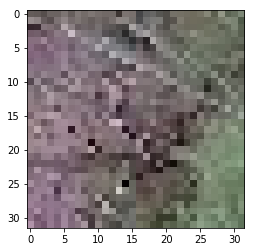

In [2]:
check_img = mpimg.imread('../input/train/train/008bd3d84a1145e154409c124de7cee9.jpg')
imgplot = plt.imshow(check_img)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(rate = 0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

opt = optimizers.Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
#refer to link for loading datasets https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
#refer to link for information on ImageDataGenerator (without arguments, it doesn't augment data) https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

b = 32 #batch size
train_y = pd.read_csv('../input/train.csv', dtype = 'str')
train_x = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)
train_generator = train_x.flow_from_dataframe(dataframe = train_y, directory = '../input/train/train', x_col = "id", y_col = "has_cactus" ,subset = "training", target_size = (150, 150), batch_size = b, class_mode = 'binary', shuffle = True, color_mode = 'rgb')
valid_generator = train_x.flow_from_dataframe(dataframe = train_y, directory = '../input/train/train', x_col = "id", y_col = "has_cactus", subset = "validation", target_size = (150, 150), batch_size = b, class_mode = 'binary', shuffle = True, color_mode = 'rgb')

In [ ]:
test_x = ImageDataGenerator(rescale = 1./255.)
test_y = pd.read_csv('../input/sample_submission.csv', dtype = 'str')
test_generator = test_x.flow_from_dataframe(dataframe = test_y, directory = '../input/test/test', x_col = "id", y_col = None, target_size = (150, 150), batch_size = b, class_mode = None, shuffle = False, color_mode = 'rgb')

In [ ]:
steps_train = train_generator.n//train_generator.batch_size
steps_valid = valid_generator.n//valid_generator.batch_size
steps_test = test_generator.n//test_generator.batch_size

h = model.fit_generator(generator = train_generator, steps_per_epoch = steps_train, validation_data = valid_generator, validation_steps = steps_valid, epochs = 20)

In [ ]:
h.history.keys()
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title("Accuracy in training and test set")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(["Train", "Test"], loc = 'upper_left')
plt.show()

In [ ]:
model.evaluate_generator(generator = valid_generator, steps = steps_test)

In [ ]:
test_generator.reset()
pred = model.predict_generator(generator = test_generator, steps = steps_test, verbose = 1)

In [ ]:
submit = pd.DataFrame({'id': test_y['id'], 'has_cactus': pred[:,0]})
submit.to_csv('submission.csv', index = False)